# Homework 3
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right?

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [1]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.3.0+cu100
# CUDA enabled: True

Version 1.3.1+cu100
CUDA enabled: True


In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [3]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework3/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

--2019-11-17 05:07:28--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  2.50MB/s    in 0.9s    

2019-11-17 05:07:29 (2.50 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py


In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [0]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing

    data = ' '.join(data.split())
        
    voc2ind = {}
    classId = 0
    out = []
   
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
      # TODO Fill this in
      if char not in voc2ind:
        voc2ind[char] = classId
        classId += 1
      out.append(voc2ind[char])
    
    
    ind2voc = {val: key for key, val in voc2ind.items()}

    save_out = np.array(out)

    train_ind = int(0.80*save_out.shape[0])

    train_text = save_out[0:train_ind]
    test_text = save_out[train_ind:]
    
    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [0]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)
        
        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        data = dataset['tokens']

        if(data.shape[0]%batch_size != 0):
          end = -1*int(data.shape[0]%batch_size)
          data = data[0:end]

        self.data = np.reshape(data,(self.batch_size,-1))
  
    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         cols = self.data.shape[1]
         sequences_per_row = (cols-1)//self.sequence_length + int(((cols-1)%self.sequence_length)>0)
         tot_sequences = sequences_per_row*self.batch_size
         return tot_sequences 
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        col_start = (idx//self.batch_size)*self.sequence_length
        row = idx%self.batch_size
        
        if(len(self.data[row,col_start:])>self.sequence_length):
          col_end = col_start+self.sequence_length+1
          
        else:
          col_end = self.data.shape[1]

        data = self.data[row,col_start:col_end]  
        data = torch.LongTensor(data)

        type(data)
        
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [0]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, num_layers=1, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        
        x, hidden_state = self.gru(x,hidden_state)
        
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [0]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    device = hidden.device
    output = output.argmax()
    outputs.append(output)
    output.to(device)
    for ii in range(sequence_length):
        output, hidden = model.inference(output,hidden,TEMPERATURE)
        output = output.argmax()
        outputs.append(output)
        output.to(device)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    device = hidden.device
    output = torch.multinomial(output, 1)
    outputs.append(output)
    output.to(device)
    for ii in range(sequence_length):
        output, hidden = model.inference(output,hidden,TEMPERATURE)
        output = torch.multinomial(output,1)
        outputs.append(output) 
        output.to(device)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    device = hidden.device
    beam = [([], output, hidden, 0)]
    for ii in range(sequence_length):
      new_beam = []
      for val in beam:
        a,b,c,d = val
        b.to(device)
        c.to(device)
        g = torch.multinomial(b,beam_width)
        g = g[0]
        for idx in g:
          temp = a.copy()
          idx.to(device)
          n_score = d+torch.log(b[0,idx])
          n_o, n_h = model.inference(idx,c)
          temp.append(idx)
          new_beam.append((temp,n_o,n_h,n_score))    
      tempn = sorted(new_beam,key=lambda x:x[3],reverse=True)          
      beam = tempn[:10]
    tempnn = sorted(beam,key=lambda x:x[3],reverse=True)
    outputs = tempnn[0][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [0]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	 mOO{$$n:TTK`01dO{{$1$$n$xL1111d}2Kne $$$CR~ Stq}}U`00n~$$Fs}}}}2Kn::1/G`}ibR9zn~6ff7ZO:TCXf`::1m`%s


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	Ce6::6nDKKnnnD$fne $$$,$R;O%sNNaO2KKKKKnnnnIt{$nD$no$eCOTR1Dn}KKnT=aO::$1 $$${$KFL} [1t{KnnKKnee{$rr


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	2r$fCCxO$1;OcOTiiG11OT1`TKKnn[nlK{nn nnKKnnsmmd%TTKO.DD$$$nTRR%nR:1$$$$$nnnfOnR{nKnCCCCK{nnnn$Rz"%sN


Input	 hel

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 22.5911, Accuracy: 15754/1260000 (1%)



  1%|          | 2/195 [00:00<00:38,  5.05it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 22.519093


  6%|▌         | 12/195 [00:01<00:26,  7.03it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 31.556160


 11%|█▏        | 22/195 [00:03<00:23,  7.27it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 13.070028


 16%|█▋        | 32/195 [00:04<00:22,  7.13it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 8.152582


 22%|██▏       | 42/195 [00:05<00:20,  7.31it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 6.910163


 27%|██▋       | 52/195 [00:07<00:19,  7.28it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 5.032285


 32%|███▏      | 62/195 [00:08<00:18,  7.12it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 4.729301


 37%|███▋      | 72/195 [00:10<00:16,  7.24it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 4.613913


 42%|████▏     | 82/195 [00:11<00:15,  7.26it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 3.682610


 47%|████▋     | 92/195 [00:12<00:14,  7.18it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 3.030510


 52%|█████▏    | 102/195 [00:14<00:12,  7.29it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 2.765766


 57%|█████▋    | 112/195 [00:15<00:11,  7.29it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 3.310444


 63%|██████▎   | 122/195 [00:16<00:10,  7.29it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 2.936039


 68%|██████▊   | 132/195 [00:18<00:08,  7.34it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 2.616696


 73%|███████▎  | 142/195 [00:19<00:07,  7.13it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 2.457408


 78%|███████▊  | 152/195 [00:21<00:05,  7.24it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 2.446786


 83%|████████▎ | 162/195 [00:22<00:04,  7.16it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 2.519312


 88%|████████▊ | 172/195 [00:23<00:03,  7.21it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 2.442046


 93%|█████████▎| 182/195 [00:25<00:01,  7.03it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 2.251398


 98%|█████████▊| 192/195 [00:26<00:00,  7.27it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 2.285127


100%|██████████| 195/195 [00:27<00:00,  7.20it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rlooat saggtHnd raas,d stain,,ethe cape eooask ."H mn Parre".. He fapd  "Iun'y wauky, Iale" said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eseed toe lnt reeane  end Harry larped tumbledore teck bn o the lna laetay. etoet sogee  ooe gaeaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	neleng ond leeepeng ln the lelele cn ehe lenknlaghtblooeluonvtagsaetle ""er Tkl ga'roeee tetent.larr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Harry, Ron, Harry, Harry knoward Harry laud, Harry laught out of the really Harry knoward Harry laud, Harry laught out over through Harry knoward Harry laud, Harry laught out over through Harry looked



  1%|          | 2/195 [00:00<00:38,  5.08it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 2.612686


  6%|▌         | 12/195 [00:01<00:26,  7.00it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 2.349157


 11%|█▏        | 22/195 [00:03<00:24,  7.15it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 2.271153


 16%|█▋        | 32/195 [00:04<00:22,  7.11it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 2.082983


 22%|██▏       | 42/195 [00:05<00:21,  7.13it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.987756


 27%|██▋       | 52/195 [00:07<00:20,  7.10it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.913624


 32%|███▏      | 62/195 [00:08<00:18,  7.23it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 2.153206


 37%|███▋      | 72/195 [00:10<00:17,  7.14it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.968173


 42%|████▏     | 82/195 [00:11<00:15,  7.11it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.839333


 47%|████▋     | 92/195 [00:12<00:14,  6.96it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.778669


 52%|█████▏    | 102/195 [00:14<00:13,  7.12it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.892630


 57%|█████▋    | 112/195 [00:15<00:11,  7.07it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.926569


 63%|██████▎   | 122/195 [00:17<00:10,  7.00it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.917784


 68%|██████▊   | 132/195 [00:18<00:08,  7.03it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.814739


 73%|███████▎  | 142/195 [00:20<00:07,  6.99it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.856031


 78%|███████▊  | 152/195 [00:21<00:06,  7.10it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 2.183249


 83%|████████▎ | 162/195 [00:22<00:04,  6.95it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.870197


 88%|████████▊ | 172/195 [00:24<00:03,  7.06it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.744755


 93%|█████████▎| 182/195 [00:25<00:01,  7.06it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.679700


 98%|█████████▊| 192/195 [00:27<00:00,  7.06it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.684875


100%|██████████| 195/195 [00:27<00:00,  7.09it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	ngoeet soghttnd sotstd tnain   the sore  oohsk. "I sn shrk, .  "e said  "Ion'  harky, ttt,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	oss d hhe stt r oore  hnd herry faap d humbledore seck on o hhe ssc.foet.yc .ohet horled ohe sooaole


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	re .ng hld heep eng hn hhe sosdle of hhe serk sashttlooen ot togsmetne  "rr hp  oelroble oesent oarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Professor McGonagally. "I should he said quickly. "I should have been the something voice. "I should he said quickly. "I should have been out of the something out of his had been the something he had 



  1%|          | 2/195 [00:00<00:38,  4.98it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.711198


  6%|▌         | 12/195 [00:01<00:25,  7.04it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.737308


 11%|█▏        | 22/195 [00:03<00:24,  7.11it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.703173


 16%|█▋        | 32/195 [00:04<00:22,  7.15it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.790958


 22%|██▏       | 42/195 [00:05<00:21,  7.06it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.816430


 27%|██▋       | 52/195 [00:07<00:20,  7.05it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.796703


 32%|███▏      | 62/195 [00:08<00:18,  7.12it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.752190


 37%|███▋      | 72/195 [00:10<00:17,  7.14it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.669714


 42%|████▏     | 82/195 [00:11<00:15,  7.18it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.689946


 47%|████▋     | 92/195 [00:12<00:14,  7.20it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.757024


 52%|█████▏    | 102/195 [00:14<00:12,  7.18it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.686811


 57%|█████▋    | 112/195 [00:15<00:11,  7.08it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.611076


 63%|██████▎   | 122/195 [00:17<00:10,  7.15it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.663735


 68%|██████▊   | 132/195 [00:18<00:08,  7.05it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.644298


 73%|███████▎  | 142/195 [00:20<00:07,  7.08it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.651423


 78%|███████▊  | 152/195 [00:21<00:06,  7.09it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.681348


 83%|████████▎ | 162/195 [00:22<00:04,  7.11it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.915097


 88%|████████▊ | 172/195 [00:24<00:03,  7.22it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.726551


 93%|█████████▎| 182/195 [00:25<00:01,  7.08it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.600734


 98%|█████████▊| 192/195 [00:27<00:00,  7.14it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.572137


100%|██████████| 195/195 [00:27<00:00,  7.11it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rloeet solnttnd sitsdd ttain,t the torereoaask  "H tm shrr,... "e said  "Iin't barky  tod," said Her


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ess d hoe ctt r hore  tnd herry seap d hembledore seck on o hhe cnr loer,yer.thet herled hoe coeeede


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne .ng hld heenpeng hn the cogdle on the cerk heshttnoien an tegwmeeded "or Mn  oelrible tesent oarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Hermione," said Hermione," said Hermione," said Hermione," said Hermione," said Hermione," said Dumbledore...." said Hermione," said Hermione...." said Hermione...." said Hermione...." "What?" said Ro



  1%|          | 2/195 [00:00<00:38,  5.04it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.593861


  6%|▌         | 12/195 [00:01<00:25,  7.13it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.580520


 11%|█▏        | 22/195 [00:03<00:24,  7.16it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.810393


 16%|█▋        | 32/195 [00:04<00:22,  7.17it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.794361


 22%|██▏       | 42/195 [00:05<00:21,  7.17it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.639522


 27%|██▋       | 52/195 [00:07<00:20,  7.11it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.556168


 32%|███▏      | 62/195 [00:08<00:18,  7.10it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.547092


 37%|███▋      | 72/195 [00:10<00:17,  7.02it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.564863


 42%|████▏     | 82/195 [00:11<00:15,  7.11it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.561804


 47%|████▋     | 92/195 [00:12<00:14,  7.14it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.690204


 52%|█████▏    | 102/195 [00:14<00:13,  7.06it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.642950


 57%|█████▋    | 112/195 [00:15<00:11,  7.06it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.562048


 63%|██████▎   | 122/195 [00:17<00:10,  7.05it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.554834


 68%|██████▊   | 132/195 [00:18<00:08,  7.06it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.546653


 73%|███████▎  | 142/195 [00:20<00:07,  7.09it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.549439


 78%|███████▊  | 152/195 [00:21<00:06,  6.92it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.548739


 83%|████████▎ | 162/195 [00:22<00:04,  7.03it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.533420


 88%|████████▊ | 172/195 [00:24<00:03,  7.03it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.899913


 93%|█████████▎| 182/195 [00:25<00:01,  7.03it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.714048


 98%|█████████▊| 192/195 [00:27<00:00,  7.11it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.594398


100%|██████████| 195/195 [00:27<00:00,  7.10it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nwreat aelntand sotntd tnain.t the sane eaaask  "H am ah k, .  "e said  "Hun't warky,"ttt," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ews d toe stt l aane "tnd harry aaap d tumbledore aack on o the snc aeet,yed.ahet horled ooe saeaede


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng a d heenpeng hn the sagdle of the serk,aaghtalouan an tagsmeade  "or an  oewrible tevent oarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Professor McGonagall was a long with the stretched and he was a long with a little with a little of the still of the was a long with a little with a little with a little with a little with and he was 



  1%|          | 2/195 [00:00<00:37,  5.13it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.601990


  6%|▌         | 12/195 [00:01<00:25,  7.08it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.525368


 11%|█▏        | 22/195 [00:03<00:24,  7.18it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.521452


 16%|█▋        | 32/195 [00:04<00:22,  7.18it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.542119


 22%|██▏       | 42/195 [00:05<00:21,  7.15it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.520861


 27%|██▋       | 52/195 [00:07<00:20,  7.07it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.517682


 32%|███▏      | 62/195 [00:08<00:18,  7.16it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.533361


 37%|███▋      | 72/195 [00:10<00:17,  7.12it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.510076


 42%|████▏     | 82/195 [00:11<00:15,  7.07it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.489541


 47%|████▋     | 92/195 [00:12<00:14,  7.16it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.543545


 52%|█████▏    | 102/195 [00:14<00:13,  7.04it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 2.085388


 57%|█████▋    | 112/195 [00:15<00:11,  7.18it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.781935


 63%|██████▎   | 122/195 [00:17<00:10,  6.99it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.619622


 68%|██████▊   | 132/195 [00:18<00:08,  7.02it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.553904


 73%|███████▎  | 142/195 [00:20<00:07,  7.13it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.502900


 78%|███████▊  | 152/195 [00:21<00:05,  7.22it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.484398


 83%|████████▎ | 162/195 [00:22<00:04,  7.06it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.500949


 88%|████████▊ | 172/195 [00:24<00:03,  7.18it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.453509


 93%|█████████▎| 182/195 [00:25<00:01,  7.10it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.471058


 98%|█████████▊| 192/195 [00:27<00:00,  7.12it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.477777


100%|██████████| 195/195 [00:27<00:00,  7.11it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rfoeetesegnttnd soavdd tnainst the coue eetasks "H hm sh'k,..  "e said  "Hun't yauky,"tot," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed hhe ctt d home "tnd harry saad d humbledore,heck onto the cne heeteyed.thet herled hhe coeaede


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	neleng hld hoeppeng hntthe cogdle of the cerkshash tluuet ttttagsmeaded "ir tne oelrible tesent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Dumbledore. "Harry," said Dumbledore," said Dumbledore. "Harry," said Dumbledore," said Dumbledore," said Dumbledore," said Dumbledore," said Dumbledore," said Dumbledore," said Dumbledore," said Harr



  1%|          | 2/195 [00:00<00:36,  5.26it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.513029


  6%|▌         | 12/195 [00:01<00:25,  7.17it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.478934


 11%|█▏        | 22/195 [00:03<00:24,  7.12it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.494026


 16%|█▋        | 32/195 [00:04<00:23,  6.99it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.651671


 22%|██▏       | 42/195 [00:05<00:21,  7.05it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.567539


 27%|██▋       | 52/195 [00:07<00:20,  7.07it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.488275


 32%|███▏      | 62/195 [00:08<00:18,  7.09it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.481417


 37%|███▋      | 72/195 [00:10<00:17,  7.19it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.467268


 42%|████▏     | 82/195 [00:11<00:15,  7.13it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.477076


 47%|████▋     | 92/195 [00:12<00:14,  7.16it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.700005


 52%|█████▏    | 102/195 [00:14<00:13,  7.13it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.564157


 57%|█████▋    | 112/195 [00:15<00:11,  7.10it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.486834


 63%|██████▎   | 122/195 [00:17<00:10,  7.12it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.468984


 68%|██████▊   | 132/195 [00:18<00:08,  7.23it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.491955


 73%|███████▎  | 142/195 [00:19<00:07,  7.06it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.449706


 78%|███████▊  | 152/195 [00:21<00:06,  6.94it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.466638


 83%|████████▎ | 162/195 [00:22<00:04,  7.16it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.435117


 88%|████████▊ | 172/195 [00:24<00:03,  7.12it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.567113


 93%|█████████▎| 182/195 [00:25<00:01,  7.10it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.625530


 98%|█████████▊| 192/195 [00:26<00:00,  7.10it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.546919


100%|██████████| 195/195 [00:27<00:00,  7.12it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rrreeteaegntand liaved tnain.t the canereeaask  "Y tl sirk, .  He said  "Yon'  yarky,"tod," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ess d toe btt l aole  tnd tarry aaad d tumbledore.aeck tnto the cne atet,yer.aoet torlid toe caeaede


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nereng ald loapping an the cogdle of the cerk,aashtatoueteat tagsmeade  "or an  oelrible tosent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Professor McGonagall, looking and looking and looking around and looking about of the close and looking about of the walking about of them. Harry was looking around and looking about of the close and 



  1%|          | 2/195 [00:00<00:38,  5.02it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.544127


  6%|▌         | 12/195 [00:01<00:26,  7.01it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.488213


 11%|█▏        | 22/195 [00:03<00:24,  7.12it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.452328


 16%|█▋        | 32/195 [00:04<00:22,  7.12it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.473119


 22%|██▏       | 42/195 [00:05<00:21,  7.13it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.435200


 27%|██▋       | 52/195 [00:07<00:20,  7.10it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.497735


 32%|███▏      | 62/195 [00:08<00:18,  7.02it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.510645


 37%|███▋      | 72/195 [00:10<00:17,  7.09it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.531697


 42%|████▏     | 82/195 [00:11<00:15,  7.23it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.444745


 47%|████▋     | 92/195 [00:13<00:14,  7.08it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.447588


 52%|█████▏    | 102/195 [00:14<00:12,  7.19it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.519459


 57%|█████▋    | 112/195 [00:15<00:11,  7.11it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.454439


 63%|██████▎   | 122/195 [00:17<00:10,  7.00it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.440694


 68%|██████▊   | 132/195 [00:18<00:08,  7.12it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.464028


 73%|███████▎  | 142/195 [00:20<00:07,  6.99it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.459915


 78%|███████▊  | 152/195 [00:21<00:06,  7.13it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.448183


 83%|████████▎ | 162/195 [00:22<00:04,  7.05it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.429566


 88%|████████▊ | 172/195 [00:24<00:03,  6.98it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.491564


 93%|█████████▎| 182/195 [00:25<00:01,  7.09it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.443392


 98%|█████████▊| 192/195 [00:27<00:00,  7.08it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.437048


100%|██████████| 195/195 [00:27<00:00,  7.08it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rloeet aegnttnd sotved tnainst the clse eeaask. "I sl sork,".  "e said  "Ion'  yarky,"tod," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed toe ctt s aole  tnd harry haap d humbledore.teck tn o the cne coet,yed.ahet honled ooe sleaede


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	neleng ald soeppeng hn the sogdle of the corksaash tluuen at tagsmeaded "or an  oelrible torent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Dumbledore," said Harry. "What's that's they haven't seemed," said Dumbledore," said Dumbledore," said Dumbledore," said Harry. "You haven't seemed," said Dumbledore," said Dumbledore. "You haven't se



  1%|          | 2/195 [00:00<00:39,  4.92it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.455715


  6%|▌         | 12/195 [00:01<00:26,  6.90it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.444775


 11%|█▏        | 22/195 [00:03<00:24,  7.11it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.525033


 16%|█▋        | 32/195 [00:04<00:22,  7.15it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 2.237451


 22%|██▏       | 42/195 [00:06<00:21,  6.98it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.764800


 27%|██▋       | 52/195 [00:07<00:19,  7.15it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.544636


 32%|███▏      | 62/195 [00:08<00:18,  7.15it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.488061


 37%|███▋      | 72/195 [00:10<00:17,  7.19it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.452293


 42%|████▏     | 82/195 [00:11<00:16,  7.06it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.413362


 47%|████▋     | 92/195 [00:13<00:14,  7.22it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.417633


 52%|█████▏    | 102/195 [00:14<00:12,  7.16it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.426614


 57%|█████▋    | 112/195 [00:15<00:11,  7.19it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.413120


 63%|██████▎   | 122/195 [00:17<00:10,  7.07it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.454533


 68%|██████▊   | 132/195 [00:18<00:08,  7.04it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.486569


 73%|███████▎  | 142/195 [00:20<00:07,  6.97it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.430432


 78%|███████▊  | 152/195 [00:21<00:06,  6.95it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.449131


 83%|████████▎ | 162/195 [00:22<00:04,  7.12it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.423254


 88%|████████▊ | 172/195 [00:24<00:03,  7.11it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.457736


 93%|█████████▎| 182/195 [00:25<00:01,  7.00it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.530295


 98%|█████████▊| 192/195 [00:27<00:00,  7.06it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.453980


100%|██████████| 195/195 [00:27<00:00,  7.07it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet aedhttnd soavdd anainst the shse  oaask  "I ss so k, .  se said  "Ion'  sarky "Iot," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ess d toe stt s ahse  tnd sarry saap d aumbledore aeck on o the sne atet,yer aoet horl d ooe sheaele


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng atd soappeng hn the saddle of the sork aash anuuetaan tagwmeade  "or af  oelrible aosent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Harry was supposed to be about of his wand and looking around as he was a looking out of his wand and looking around that he was a looking out of his wand and looking around as he was a looking around



  1%|          | 2/195 [00:00<00:36,  5.26it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.490493


  6%|▌         | 12/195 [00:01<00:26,  6.99it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.449037


 11%|█▏        | 22/195 [00:03<00:24,  7.07it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.425647


 16%|█▋        | 32/195 [00:04<00:22,  7.14it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.471623


 22%|██▏       | 42/195 [00:06<00:21,  7.07it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.750397


 27%|██▋       | 52/195 [00:07<00:19,  7.16it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.521302


 32%|███▏      | 62/195 [00:08<00:18,  7.07it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.466428


 37%|███▋      | 72/195 [00:10<00:17,  7.07it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.419979


 42%|████▏     | 82/195 [00:11<00:15,  7.07it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.389360


 47%|████▋     | 92/195 [00:13<00:14,  7.17it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.400677


 52%|█████▏    | 102/195 [00:14<00:13,  7.09it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.437776


 57%|█████▋    | 112/195 [00:15<00:11,  7.04it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.441084


 63%|██████▎   | 122/195 [00:17<00:10,  7.10it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.421458


 68%|██████▊   | 132/195 [00:18<00:08,  7.02it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.494893


 73%|███████▎  | 142/195 [00:20<00:07,  6.96it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.458124


 78%|███████▊  | 152/195 [00:21<00:06,  7.01it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.460517


 83%|████████▎ | 162/195 [00:22<00:04,  7.11it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.478005


 88%|████████▊ | 172/195 [00:24<00:03,  7.15it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.425248


 93%|█████████▎| 182/195 [00:25<00:01,  7.05it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.400667


 98%|█████████▊| 192/195 [00:27<00:00,  7.12it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.411891


100%|██████████| 195/195 [00:27<00:00,  7.08it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rlreeteaednttnd soaded tnain.t the corer eaask. "I'sl Ihrr,..  "e said  "Ion't bauky,"Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the btt s aore  tnd sarry haaded humbledore.weck onto the cne aoet,yer.ahet horled ohe cooaele


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nereng ald soeppeng hntthe cagdle of the cerk aash anuuenuanttagwmeaded "or an  oelrible torent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Dumbledore. "What's what?" said Professor McGonagall. "What's what?" said Professor McGonagall. "What's what?" said Dumbledore. "What's what?" said Professor McGonagall. "What's what?" said Hermione. 



  1%|          | 2/195 [00:00<00:38,  5.00it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.430019


  6%|▌         | 12/195 [00:01<00:26,  6.92it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.465492


 11%|█▏        | 22/195 [00:03<00:24,  7.08it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.481887


 16%|█▋        | 32/195 [00:04<00:22,  7.14it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.988417


 22%|██▏       | 42/195 [00:06<00:21,  7.03it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.585741


 27%|██▋       | 52/195 [00:07<00:20,  7.03it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.472299


 32%|███▏      | 62/195 [00:08<00:18,  7.16it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.435859


 37%|███▋      | 72/195 [00:10<00:17,  7.00it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.407652


 42%|████▏     | 82/195 [00:11<00:15,  7.11it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.381984


 47%|████▋     | 92/195 [00:13<00:14,  7.02it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.401550


 52%|█████▏    | 102/195 [00:14<00:13,  7.06it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.442796


 57%|█████▋    | 112/195 [00:15<00:11,  7.07it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.402731


 63%|██████▎   | 122/195 [00:17<00:10,  7.14it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.419986


 68%|██████▊   | 132/195 [00:18<00:08,  7.07it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.487769


 73%|███████▎  | 142/195 [00:20<00:07,  7.08it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.443203


 78%|███████▊  | 152/195 [00:21<00:06,  7.14it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.425014


 83%|████████▎ | 162/195 [00:22<00:04,  7.12it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.425747


 88%|████████▊ | 172/195 [00:24<00:03,  7.05it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.446991


 93%|█████████▎| 182/195 [00:25<00:01,  7.06it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.410963


 98%|█████████▊| 192/195 [00:27<00:00,  7.13it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.421975


100%|██████████| 195/195 [00:27<00:00,  7.08it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rlreeteteghttnd sotved tnain.t the cose eeoisk. "I'dluIhrr,..  "e said  "Iin't yhuky, Iot," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed hhe ctt s thue  tnd harry saaped humbledore.ceck tnto the cne htct,yer.thet hortid ihe cheaele


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nereng htd hreppeng hntthe casdle of the cerkshashttnuuenuatttagwmeaded "ur sne oelrible tesent.tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said the window. Harry looked up into the floor behind him. Harry hadn't seemed to getting he had been the entrance he had been the entrance he couldn't been them... he hadn't been them... he had been the 



  1%|          | 2/195 [00:00<00:37,  5.09it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.464686


  6%|▌         | 12/195 [00:01<00:26,  6.92it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.598017


 11%|█▏        | 22/195 [00:03<00:24,  7.04it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.795021


 16%|█▋        | 32/195 [00:04<00:22,  7.10it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.569761


 22%|██▏       | 42/195 [00:05<00:21,  7.22it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.455321


 27%|██▋       | 52/195 [00:07<00:20,  7.11it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.420049


 32%|███▏      | 62/195 [00:08<00:18,  7.16it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.422856


 37%|███▋      | 72/195 [00:10<00:17,  7.18it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.399559


 42%|████▏     | 82/195 [00:11<00:15,  7.18it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.384601


 47%|████▋     | 92/195 [00:13<00:14,  7.06it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.400527


 52%|█████▏    | 102/195 [00:14<00:13,  6.98it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.440358


 57%|█████▋    | 112/195 [00:15<00:11,  6.96it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.481710


 63%|██████▎   | 122/195 [00:17<00:10,  7.14it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.486467


 68%|██████▊   | 132/195 [00:18<00:08,  7.16it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.460788


 73%|███████▎  | 142/195 [00:20<00:07,  7.08it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.432351


 78%|███████▊  | 152/195 [00:21<00:05,  7.18it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.399276


 83%|████████▎ | 162/195 [00:22<00:04,  7.17it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.410953


 88%|████████▊ | 172/195 [00:24<00:03,  7.11it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.407586


 93%|█████████▎| 182/195 [00:25<00:01,  7.13it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.418904


 98%|█████████▊| 192/195 [00:27<00:00,  7.13it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.407872


100%|██████████| 195/195 [00:27<00:00,  7.10it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet ahgntand soaved tnain,t the sose  eoisl. "I sl so r,".  "e said  "Ion'  yauky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed toe ctt s tore  tnd sarry sa p d humbledore weck tn o the cnu atct,yer.thet horl d ohe soeaeni


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nereng ard sreppeng hn the sasdle of the serk aash anuuesuan tagsmeade  "or an  oelroble terent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Professor McGonagall, and Harry looked up at Harry and he could have been the floor behind he could have been the floor behind he could have been the floor something behind he could have been remember



  1%|          | 2/195 [00:00<00:37,  5.19it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.435869


  6%|▌         | 12/195 [00:01<00:25,  7.04it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.413422


 11%|█▏        | 22/195 [00:03<00:24,  7.14it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.516705


 16%|█▋        | 32/195 [00:04<00:22,  7.13it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.893331


 22%|██▏       | 42/195 [00:05<00:22,  6.90it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.655437


 27%|██▋       | 52/195 [00:07<00:20,  7.13it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.490500


 32%|███▏      | 62/195 [00:08<00:18,  7.13it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.440511


 37%|███▋      | 72/195 [00:10<00:17,  7.22it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.407697


 42%|████▏     | 82/195 [00:11<00:15,  7.10it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.388397


 47%|████▋     | 92/195 [00:12<00:14,  7.20it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.391364


 52%|█████▏    | 102/195 [00:14<00:13,  7.10it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.402509


 57%|█████▋    | 112/195 [00:15<00:11,  7.08it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.379049


 63%|██████▎   | 122/195 [00:17<00:10,  7.23it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.465641


 68%|██████▊   | 132/195 [00:18<00:08,  7.20it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.449677


 73%|███████▎  | 142/195 [00:20<00:07,  7.06it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.413551


 78%|███████▊  | 152/195 [00:21<00:06,  7.01it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.409403


 83%|████████▎ | 162/195 [00:22<00:04,  6.94it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.423413


 88%|████████▊ | 172/195 [00:24<00:03,  7.06it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.382568


 93%|█████████▎| 182/195 [00:25<00:01,  7.09it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.374016


 98%|█████████▊| 192/195 [00:27<00:00,  7.06it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.422444


100%|██████████| 195/195 [00:27<00:00,  7.09it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet ahghtond soav d a oin t the cose  ooisk  "I dm so r, .  "e said  "Ion't yauky  Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ess d hoe ctt   oore  and sarry wa p d oumbledore weck on o the cnu coer,yed aoen horl d ooe sooaele


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	me  ng a d soeppeng hn the sosdly of the cork aash anuuen an tagwmeade  "or an  oelroble sosent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Harry would have been a looked out of the window. Harry would have been a looked out of the window. Harry would have been a looked out of the other side of the window. Harry would have been looked up 



  1%|          | 2/195 [00:00<00:38,  4.96it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.508452


  6%|▌         | 12/195 [00:01<00:25,  7.09it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.465943


 11%|█▏        | 22/195 [00:03<00:24,  7.09it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.432137


 16%|█▋        | 32/195 [00:04<00:22,  7.11it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.438656


 22%|██▏       | 42/195 [00:05<00:21,  7.16it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.528773


 27%|██▋       | 52/195 [00:07<00:20,  7.04it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.485114


 32%|███▏      | 62/195 [00:08<00:18,  7.16it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.450774


 37%|███▋      | 72/195 [00:10<00:17,  7.19it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.412766


 42%|████▏     | 82/195 [00:11<00:15,  7.13it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.376880


 47%|████▋     | 92/195 [00:12<00:14,  7.07it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.392082


 52%|█████▏    | 102/195 [00:14<00:12,  7.19it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.402980


 57%|█████▋    | 112/195 [00:15<00:11,  7.06it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.382583


 63%|██████▎   | 122/195 [00:17<00:10,  7.19it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.402312


 68%|██████▊   | 132/195 [00:18<00:08,  7.09it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.453242


 73%|███████▎  | 142/195 [00:20<00:07,  6.99it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.440894


 78%|███████▊  | 152/195 [00:21<00:06,  7.07it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.428496


 83%|████████▎ | 162/195 [00:22<00:04,  7.08it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.482588


 88%|████████▊ | 172/195 [00:24<00:03,  7.07it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.483090


 93%|█████████▎| 182/195 [00:25<00:01,  7.16it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.410171


 98%|█████████▊| 192/195 [00:27<00:00,  7.25it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.399062


100%|██████████| 195/195 [00:27<00:00,  7.10it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet aegntand soaved anain,t the sase  eoisk. "I dm so'r,".  "e said  "Iin'  wanky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed toe stt l thre  tnd sarry saaped tumbledore seck tnto the cne whir,yer.ahet honted ohe shiaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nereng and soanpeng an the sagdle of the sork aash anuumnsan tagwmeade  "ur an  oelroble sorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Dumbledore. Harry had been seemed toward the window. Harry wasn't seemed to be about the other side of the other side of them. Harry wasn't seemed to be about the back out of the window. Harry wasn't 



  1%|          | 2/195 [00:00<00:38,  5.08it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.417683


  6%|▌         | 12/195 [00:01<00:26,  6.88it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.415496


 11%|█▏        | 22/195 [00:03<00:24,  7.04it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.427276


 16%|█▋        | 32/195 [00:04<00:22,  7.27it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.506364


 22%|██▏       | 42/195 [00:05<00:21,  7.13it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.433127


 27%|██▋       | 52/195 [00:07<00:20,  7.14it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.401454


 32%|███▏      | 62/195 [00:08<00:18,  7.07it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.409228


 37%|███▋      | 72/195 [00:10<00:17,  7.12it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.399047


 42%|████▏     | 82/195 [00:11<00:16,  7.03it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.382756


 47%|████▋     | 92/195 [00:12<00:14,  7.15it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.394018


 52%|█████▏    | 102/195 [00:14<00:12,  7.22it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.400844


 57%|█████▋    | 112/195 [00:15<00:11,  7.29it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.419848


 63%|██████▎   | 122/195 [00:17<00:10,  7.11it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.472202


 68%|██████▊   | 132/195 [00:18<00:08,  7.02it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.476713


 73%|███████▎  | 142/195 [00:20<00:07,  7.01it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.432297


 78%|███████▊  | 152/195 [00:21<00:06,  7.11it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.397380


 83%|████████▎ | 162/195 [00:22<00:04,  7.12it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.391892


 88%|████████▊ | 172/195 [00:24<00:03,  7.11it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.421876


 93%|█████████▎| 182/195 [00:25<00:01,  7.18it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.427479


 98%|█████████▊| 192/195 [00:27<00:00,  7.20it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.514228


100%|██████████| 195/195 [00:27<00:00,  7.12it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet ahgnttnd saar d ttain,t the caser ioisk. "I'ws nhrr,..  "e said  "Iin'  warry  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the ttt r tarer tnd tarry waap d tumbledore tack on o the cnk whct,y,r that hinl d ohe caoaini


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring ard sranping hn the sagdly of the cark aash aiuumnsan tagwmeade  "ir an  oawroble sarent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Dumbledore. Harry was so that he was on the other side of the window, as though he was so that he was on the other side of the back of the other side of the window, as though he was so that that he wa



  1%|          | 2/195 [00:00<00:36,  5.35it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.510386


  6%|▌         | 12/195 [00:01<00:25,  7.09it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.468790


 11%|█▏        | 22/195 [00:03<00:24,  7.08it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.411382


 16%|█▋        | 32/195 [00:04<00:22,  7.22it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.405505


 22%|██▏       | 42/195 [00:05<00:21,  7.18it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.414562


 27%|██▋       | 52/195 [00:07<00:20,  6.99it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.446284


 32%|███▏      | 62/195 [00:08<00:18,  7.16it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.461687


 37%|███▋      | 72/195 [00:10<00:17,  7.18it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.422970


 42%|████▏     | 82/195 [00:11<00:15,  7.15it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.379143


 47%|████▋     | 92/195 [00:12<00:14,  7.07it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.384429


 52%|█████▏    | 102/195 [00:14<00:13,  7.10it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.409389


 57%|█████▋    | 112/195 [00:15<00:11,  7.12it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.383942


 63%|██████▎   | 122/195 [00:17<00:10,  7.00it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.439189


 68%|██████▊   | 132/195 [00:18<00:08,  7.21it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.458961


 73%|███████▎  | 142/195 [00:19<00:07,  7.18it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.525679


 78%|███████▊  | 152/195 [00:21<00:06,  6.95it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.438973


 83%|████████▎ | 162/195 [00:22<00:04,  7.09it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.398764


 88%|████████▊ | 172/195 [00:24<00:03,  7.23it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.370626


 93%|█████████▎| 182/195 [00:25<00:01,  7.10it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.366663


 98%|█████████▊| 192/195 [00:26<00:00,  7.11it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.422043


100%|██████████| 195/195 [00:27<00:00,  7.12it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet aeghtand soaved t ain,t the cose  eoisk  "I dm nh r, .  "e said  "Ion't yauky  Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the ctt   hhme  wnd sarry se ped humbledore weck on o the cnh whet,ye  ahet horl   ohe soeaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne eng a d seenpeng hn the saddle of the serk hash anuee  an tagwmeade  "or an  oelroble sement aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Professor McGonagall was looking around he had been he had been seemed to the side of the window. Harry would he had been he could he had been seemed to see what he would he had been with he had been 



  1%|          | 2/195 [00:00<00:38,  5.00it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.481317


  6%|▌         | 12/195 [00:01<00:25,  7.05it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.465304


 11%|█▏        | 22/195 [00:03<00:24,  7.12it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.412316


 16%|█▋        | 32/195 [00:04<00:22,  7.11it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.402189


 22%|██▏       | 42/195 [00:05<00:21,  7.08it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.399050


 27%|██▋       | 52/195 [00:07<00:19,  7.16it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.440912


 32%|███▏      | 62/195 [00:08<00:19,  6.95it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.488093


 37%|███▋      | 72/195 [00:10<00:17,  7.13it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.402918


 42%|████▏     | 82/195 [00:11<00:15,  7.10it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.380893


 47%|████▋     | 92/195 [00:13<00:14,  7.11it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.387039


 52%|█████▏    | 102/195 [00:14<00:13,  7.15it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.392972


 57%|█████▋    | 112/195 [00:15<00:11,  7.22it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.398880


 63%|██████▎   | 122/195 [00:17<00:10,  7.23it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.412551


 68%|██████▊   | 132/195 [00:18<00:08,  7.13it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.436934


 73%|███████▎  | 142/195 [00:20<00:07,  7.09it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.424169


 78%|███████▊  | 152/195 [00:21<00:05,  7.20it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.394029


 83%|████████▎ | 162/195 [00:22<00:04,  7.19it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.429090


 88%|████████▊ | 172/195 [00:24<00:03,  6.96it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.407794


 93%|█████████▎| 182/195 [00:25<00:01,  7.09it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.381573


 98%|█████████▊| 192/195 [00:27<00:00,  7.14it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.395183


100%|██████████| 195/195 [00:27<00:00,  7.10it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreeteshghttnd sotved tnain.t the corer.eoisl. "I ds shrr,".  "e said  "Ion't warry  tor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the ctt r threr tnd sarry saaped humbledore teck tnto the cnk wtir,yer.thet hort d ihe coeaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and srenpeng hn the coddle of the cerk hash anueetean tagwmeaded "rr ane oelroble torent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Professor McGonagall, who was looking around. Harry was looking around the end of the window. Harry wouldn't seemed to be in the other. Harry had been seemed to the window. Harry would have been been 



  1%|          | 2/195 [00:00<00:39,  4.90it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.412249


  6%|▌         | 12/195 [00:01<00:26,  6.98it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.626361


 11%|█▏        | 22/195 [00:03<00:24,  7.16it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.456425


 16%|█▋        | 32/195 [00:04<00:23,  7.07it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.412738


 22%|██▏       | 42/195 [00:06<00:21,  7.16it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.409118


 27%|██▋       | 52/195 [00:07<00:20,  7.03it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.395319


 32%|███▏      | 62/195 [00:08<00:18,  7.00it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.409618


 37%|███▋      | 72/195 [00:10<00:17,  7.09it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.403680


 42%|████▏     | 82/195 [00:11<00:15,  7.15it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.387055


 47%|████▋     | 92/195 [00:13<00:14,  7.14it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.411531


 52%|█████▏    | 102/195 [00:14<00:13,  7.13it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.417491


 57%|█████▋    | 112/195 [00:15<00:11,  7.19it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.464394


 63%|██████▎   | 122/195 [00:17<00:10,  7.08it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.487571


 68%|██████▊   | 132/195 [00:18<00:08,  7.16it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.442544


 73%|███████▎  | 142/195 [00:20<00:07,  7.05it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.426784


 78%|███████▊  | 152/195 [00:21<00:05,  7.17it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.398949


 83%|████████▎ | 162/195 [00:22<00:04,  7.13it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.417854


 88%|████████▊ | 172/195 [00:24<00:03,  7.04it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.513562


 93%|█████████▎| 182/195 [00:25<00:01,  7.06it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.396912


 98%|█████████▊| 192/195 [00:27<00:00,  7.14it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.391220


100%|██████████| 195/195 [00:27<00:00,  7.10it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet aennttnd soared tnain t the sose  eoisk  "I ds nh r,".  "e said  "Ion't wanky  tor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed toe stt r oore  tnd sarry saaded tumbledore weck on o the cnk woit,yer toet torl d ooe sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne eng a d soanpeng tn the sogdle of the sork oash anuoen an tagwmeade  "or sn  oewroble sorent oarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Professor McGonagall looked out of the other side of the other side of the side of the other side of the common room of the common room of the common room of the window. Harry was looking as though he



  1%|          | 2/195 [00:00<00:36,  5.22it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.426539


  6%|▌         | 12/195 [00:01<00:26,  6.96it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.399451


 11%|█▏        | 22/195 [00:03<00:24,  7.08it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.406113


 16%|█▋        | 32/195 [00:04<00:22,  7.10it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.461576


 22%|██▏       | 42/195 [00:05<00:21,  7.13it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.418059


 27%|██▋       | 52/195 [00:07<00:20,  7.12it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.377962


 32%|███▏      | 62/195 [00:08<00:18,  7.09it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.385595


 37%|███▋      | 72/195 [00:10<00:17,  7.20it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.389891


 42%|████▏     | 82/195 [00:11<00:16,  6.99it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.431703


 47%|████▋     | 92/195 [00:13<00:14,  7.15it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.416721


 52%|█████▏    | 102/195 [00:14<00:13,  7.04it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.460212


 57%|█████▋    | 112/195 [00:15<00:11,  7.18it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.403430


 63%|██████▎   | 122/195 [00:17<00:10,  7.21it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.422741


 68%|██████▊   | 132/195 [00:18<00:08,  7.09it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.404924


 73%|███████▎  | 142/195 [00:20<00:07,  7.02it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.400183


 78%|███████▊  | 152/195 [00:21<00:06,  7.16it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.381766


 83%|████████▎ | 162/195 [00:22<00:04,  7.11it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.408230


 88%|████████▊ | 172/195 [00:24<00:03,  7.23it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.418758


 93%|█████████▎| 182/195 [00:25<00:01,  7.05it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.398964


 98%|█████████▊| 192/195 [00:27<00:00,  7.18it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.396793


100%|██████████| 195/195 [00:27<00:00,  7.09it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rloeet aegntand soaved tnain.t the cose  eoasl. "I dl noarn .  "e said  "Ion't wanky  Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed the ctt r oore  tnd tarry saaded aumbledore aack onto the cne whet,ye .thet horled ohe soeaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nereng and seenpeng hn the coddle of the cerk aash anueet an tagwmeade  "ir an  oelroble sorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Dumbledore. Harry looked as though he had been as though he would have been deeped into the other side of the window. Harry couldn't seemed to get in the common room window. Harry would have been and 



  1%|          | 2/195 [00:00<00:37,  5.11it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.414259


  6%|▌         | 12/195 [00:01<00:25,  7.05it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.409019


 11%|█▏        | 22/195 [00:03<00:24,  7.08it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.403299


 16%|█▋        | 32/195 [00:04<00:23,  7.04it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.514702


 22%|██▏       | 42/195 [00:05<00:21,  7.12it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.438772


 27%|██▋       | 52/195 [00:07<00:19,  7.19it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.382948


 32%|███▏      | 62/195 [00:08<00:18,  7.14it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.386886


 37%|███▋      | 72/195 [00:10<00:17,  7.16it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.382038


 42%|████▏     | 82/195 [00:11<00:15,  7.07it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.418798


 47%|████▋     | 92/195 [00:12<00:14,  7.22it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.396525


 52%|█████▏    | 102/195 [00:14<00:13,  7.11it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.409442


 57%|█████▋    | 112/195 [00:15<00:11,  7.14it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.360966


 63%|██████▎   | 122/195 [00:17<00:10,  7.11it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.419507


 68%|██████▊   | 132/195 [00:18<00:08,  7.08it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.403472


 73%|███████▎  | 142/195 [00:20<00:07,  6.96it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.401566


 78%|███████▊  | 152/195 [00:21<00:06,  7.06it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.382085


 83%|████████▎ | 162/195 [00:22<00:04,  7.13it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.564370


 88%|████████▊ | 172/195 [00:24<00:03,  7.12it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.675767


 93%|█████████▎| 182/195 [00:25<00:01,  6.97it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.469901


 98%|█████████▊| 192/195 [00:27<00:00,  7.10it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.427018


100%|██████████| 195/195 [00:27<00:00,  7.09it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nlreat tegntand soavid tnain t the sore  ioasks "I sl shlr,".  "e said  "Ion't warky  tor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	oused toe stt r oore  tnd tarry saaded tumbledore wack tn o the cnk whit,yed thet tort d ohe sooaent


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne ing and soanpeng hn the sigdle of the sork sash anuaat an tagwmeade  "ir sf  oelrible sorent oarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Harry, though he had been the other side of the window. Harry was looking around the end of the end of the end of the side of the corridor of the side of the window. Harry was looking as though he had



  1%|          | 2/195 [00:00<00:39,  4.90it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.424964


  6%|▌         | 12/195 [00:01<00:25,  7.04it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.395649


 11%|█▏        | 22/195 [00:03<00:24,  7.00it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.387286


 16%|█▋        | 32/195 [00:04<00:22,  7.16it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.388625


 22%|██▏       | 42/195 [00:05<00:21,  7.21it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.420527


 27%|██▋       | 52/195 [00:07<00:20,  7.09it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.377409


 32%|███▏      | 62/195 [00:08<00:18,  7.06it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.390374


 37%|███▋      | 72/195 [00:10<00:17,  7.12it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.383979


 42%|████▏     | 82/195 [00:11<00:15,  7.11it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.379380


 47%|████▋     | 92/195 [00:13<00:14,  7.12it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.388932


 52%|█████▏    | 102/195 [00:14<00:13,  7.08it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.432670


 57%|█████▋    | 112/195 [00:15<00:11,  7.13it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.374339


 63%|██████▎   | 122/195 [00:17<00:10,  6.94it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.416360


 68%|██████▊   | 132/195 [00:18<00:08,  7.17it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.421304


 73%|███████▎  | 142/195 [00:20<00:07,  7.11it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.454786


 78%|███████▊  | 152/195 [00:21<00:06,  7.12it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.424884


 83%|████████▎ | 162/195 [00:22<00:04,  7.10it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.384675


 88%|████████▊ | 172/195 [00:24<00:03,  7.13it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.356473


 93%|█████████▎| 182/195 [00:25<00:01,  7.14it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.375638


 98%|█████████▊| 192/195 [00:27<00:00,  7.10it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.426062


100%|██████████| 195/195 [00:27<00:00,  7.11it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tlreeteeelntind seaved tnain.. the carer.eoisl. "I dl nhrr,".  "e said. "Iin's wauky, Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eweed the cnt r ohrer hnd tarry waaded humbledore weck.on o the cne hhir,yed.ohet horled ihe sreaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nereng and seenpeng hn the cigdle of the cerknwash anueenean tagwmeaded "ir afe oelriele sorent,tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Harry. There was a long, he was looking around them. Harry had never seemed in the end of the window. Harry shouldered as he had been seemed to him. Harry had never seemed in the floor behind himself 



  1%|          | 2/195 [00:00<00:36,  5.26it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.559690


  6%|▌         | 12/195 [00:01<00:26,  6.97it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.430768


 11%|█▏        | 22/195 [00:03<00:24,  7.05it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.399630


 16%|█▋        | 32/195 [00:04<00:22,  7.16it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.423980


 22%|██▏       | 42/195 [00:06<00:21,  7.04it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.386509


 27%|██▋       | 52/195 [00:07<00:19,  7.21it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.362268


 32%|███▏      | 62/195 [00:08<00:18,  7.15it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.390654


 37%|███▋      | 72/195 [00:10<00:17,  7.03it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.425129


 42%|████▏     | 82/195 [00:11<00:16,  7.02it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.401304


 47%|████▋     | 92/195 [00:13<00:14,  7.03it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.418743


 52%|█████▏    | 102/195 [00:14<00:12,  7.16it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.395017


 57%|█████▋    | 112/195 [00:15<00:11,  7.04it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.361960


 63%|██████▎   | 122/195 [00:17<00:10,  7.06it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.394450


 68%|██████▊   | 132/195 [00:18<00:08,  7.13it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.398922


 73%|███████▎  | 142/195 [00:20<00:07,  7.09it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.407218


 78%|███████▊  | 152/195 [00:21<00:06,  7.12it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.388033


 83%|████████▎ | 162/195 [00:22<00:04,  7.03it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.418843


 88%|████████▊ | 172/195 [00:24<00:03,  7.22it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.479097


 93%|█████████▎| 182/195 [00:25<00:01,  7.13it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.403160


 98%|█████████▊| 192/195 [00:27<00:00,  7.14it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.378694


100%|██████████| 195/195 [00:27<00:00,  7.10it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat shgnttnd soaved tnain.t the coser eoisl  "I wl shrr,".  "e said  "Ion't wauky  tor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed toe cnt r oorer tnd sarry saaded tumbledore weck onto the cnk shir,yer.toet torled ooe sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and seenpeng hn the cogdle of the cerk oash anuean an tagwmeade  "ir sn  oelroble torent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said looking as though he couldn't seemed to have been with the common room with the common room what he had been seemed to have been with the only one of the other side of the common room with the common 



  1%|          | 2/195 [00:00<00:38,  5.02it/s]

Train Epoch: 21 [0/49920 (0%)]	Loss: 1.395516


  6%|▌         | 12/195 [00:01<00:25,  7.05it/s]

Train Epoch: 21 [2560/49920 (5%)]	Loss: 1.390852


 11%|█▏        | 22/195 [00:03<00:24,  7.11it/s]

Train Epoch: 21 [5120/49920 (10%)]	Loss: 1.393650


 16%|█▋        | 32/195 [00:04<00:22,  7.10it/s]

Train Epoch: 21 [7680/49920 (15%)]	Loss: 1.516549


 22%|██▏       | 42/195 [00:05<00:21,  7.16it/s]

Train Epoch: 21 [10240/49920 (21%)]	Loss: 1.411635


 27%|██▋       | 52/195 [00:07<00:20,  7.11it/s]

Train Epoch: 21 [12800/49920 (26%)]	Loss: 1.375107


 32%|███▏      | 62/195 [00:08<00:19,  6.93it/s]

Train Epoch: 21 [15360/49920 (31%)]	Loss: 1.387030


 37%|███▋      | 72/195 [00:10<00:17,  7.12it/s]

Train Epoch: 21 [17920/49920 (36%)]	Loss: 1.370460


 42%|████▏     | 82/195 [00:11<00:15,  7.21it/s]

Train Epoch: 21 [20480/49920 (41%)]	Loss: 1.380811


 47%|████▋     | 92/195 [00:12<00:14,  7.10it/s]

Train Epoch: 21 [23040/49920 (46%)]	Loss: 1.383705


 52%|█████▏    | 102/195 [00:14<00:13,  7.14it/s]

Train Epoch: 21 [25600/49920 (51%)]	Loss: 1.383003


 57%|█████▋    | 112/195 [00:15<00:11,  7.15it/s]

Train Epoch: 21 [28160/49920 (56%)]	Loss: 1.382700


 63%|██████▎   | 122/195 [00:17<00:10,  7.09it/s]

Train Epoch: 21 [30720/49920 (62%)]	Loss: 1.542815


 68%|██████▊   | 132/195 [00:18<00:08,  7.09it/s]

Train Epoch: 21 [33280/49920 (67%)]	Loss: 1.540776


 73%|███████▎  | 142/195 [00:20<00:07,  7.16it/s]

Train Epoch: 21 [35840/49920 (72%)]	Loss: 1.442658


 78%|███████▊  | 152/195 [00:21<00:05,  7.23it/s]

Train Epoch: 21 [38400/49920 (77%)]	Loss: 1.394367


 83%|████████▎ | 162/195 [00:22<00:04,  7.16it/s]

Train Epoch: 21 [40960/49920 (82%)]	Loss: 1.373334


 88%|████████▊ | 172/195 [00:24<00:03,  7.16it/s]

Train Epoch: 21 [43520/49920 (87%)]	Loss: 1.351834


 93%|█████████▎| 182/195 [00:25<00:01,  7.14it/s]

Train Epoch: 21 [46080/49920 (92%)]	Loss: 1.362473


 98%|█████████▊| 192/195 [00:27<00:00,  7.14it/s]

Train Epoch: 21 [48640/49920 (97%)]	Loss: 1.373376


100%|██████████| 195/195 [00:27<00:00,  7.11it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreeteselnttnd soavid tnain.t the saser.eoisls "I ws ne'r,".  "e said. "Ion't wauky, Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the snt r tarer tnd tarry saaded tumbledore aeck.tnto the cne shit,yed.thet tonled the saeaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and seanpeng hntthe cagdle of the serk aashtanaeaneanttagwmeade  "ir ane oelroele terent,tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Harry. "Yeah," said Hermione. "What's they're nothing," said Harry. "Yeah," said Harry. "What's they?" said Hermione. "What's they're nothing," said Hermione, and Harry said Harry. "What's they?" said



  1%|          | 2/195 [00:00<00:40,  4.77it/s]

Train Epoch: 22 [0/49920 (0%)]	Loss: 1.414959


  6%|▌         | 12/195 [00:01<00:26,  6.91it/s]

Train Epoch: 22 [2560/49920 (5%)]	Loss: 1.385202


 11%|█▏        | 22/195 [00:03<00:24,  7.15it/s]

Train Epoch: 22 [5120/49920 (10%)]	Loss: 1.386548


 16%|█▋        | 32/195 [00:04<00:23,  7.06it/s]

Train Epoch: 22 [7680/49920 (15%)]	Loss: 1.453056


 22%|██▏       | 42/195 [00:06<00:21,  7.03it/s]

Train Epoch: 22 [10240/49920 (21%)]	Loss: 1.409029


 27%|██▋       | 52/195 [00:07<00:20,  7.13it/s]

Train Epoch: 22 [12800/49920 (26%)]	Loss: 1.373438


 32%|███▏      | 62/195 [00:08<00:18,  7.15it/s]

Train Epoch: 22 [15360/49920 (31%)]	Loss: 1.386004


 37%|███▋      | 72/195 [00:10<00:17,  7.16it/s]

Train Epoch: 22 [17920/49920 (36%)]	Loss: 1.366942


 42%|████▏     | 82/195 [00:11<00:15,  7.20it/s]

Train Epoch: 22 [20480/49920 (41%)]	Loss: 1.372824


 47%|████▋     | 92/195 [00:13<00:14,  7.13it/s]

Train Epoch: 22 [23040/49920 (46%)]	Loss: 1.380076


 52%|█████▏    | 102/195 [00:14<00:13,  7.00it/s]

Train Epoch: 22 [25600/49920 (51%)]	Loss: 1.388166


 57%|█████▋    | 112/195 [00:15<00:11,  7.04it/s]

Train Epoch: 22 [28160/49920 (56%)]	Loss: 1.368587


 63%|██████▎   | 122/195 [00:17<00:10,  7.01it/s]

Train Epoch: 22 [30720/49920 (62%)]	Loss: 1.382597


 68%|██████▊   | 132/195 [00:18<00:08,  7.05it/s]

Train Epoch: 22 [33280/49920 (67%)]	Loss: 1.411141


 73%|███████▎  | 142/195 [00:20<00:07,  6.88it/s]

Train Epoch: 22 [35840/49920 (72%)]	Loss: 1.405360


 78%|███████▊  | 152/195 [00:21<00:06,  7.06it/s]

Train Epoch: 22 [38400/49920 (77%)]	Loss: 1.413960


 83%|████████▎ | 162/195 [00:22<00:04,  7.14it/s]

Train Epoch: 22 [40960/49920 (82%)]	Loss: 1.425811


 88%|████████▊ | 172/195 [00:24<00:03,  7.11it/s]

Train Epoch: 22 [43520/49920 (87%)]	Loss: 1.378779


 93%|█████████▎| 182/195 [00:25<00:01,  7.12it/s]

Train Epoch: 22 [46080/49920 (92%)]	Loss: 1.354816


 98%|█████████▊| 192/195 [00:27<00:00,  7.04it/s]

Train Epoch: 22 [48640/49920 (97%)]	Loss: 1.369201


100%|██████████| 195/195 [00:27<00:00,  7.07it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet segnttnd sotved tnainst the sorer.eoisls "I wr selr,".  "e said  "Ion't wauky  Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the snt r ohrer tnd sarry saaded tumbledore weck tnto the cnk otit,yer.toet torl d the soeaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nereng a d seenpeng hn the sogdle of the serk oash anuenn on tagwmeade  "ir af  oelriele sorent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Harry, who was looking as though he would have been the door of the window. Harry would have thought he would have been looking around the door of the window. Harry would have been looking around the 



  1%|          | 2/195 [00:00<00:38,  4.96it/s]

Train Epoch: 23 [0/49920 (0%)]	Loss: 1.397777


  6%|▌         | 12/195 [00:01<00:26,  6.98it/s]

Train Epoch: 23 [2560/49920 (5%)]	Loss: 1.377335


 11%|█▏        | 22/195 [00:03<00:24,  6.98it/s]

Train Epoch: 23 [5120/49920 (10%)]	Loss: 1.373798


 16%|█▋        | 32/195 [00:04<00:22,  7.17it/s]

Train Epoch: 23 [7680/49920 (15%)]	Loss: 1.433968


 22%|██▏       | 42/195 [00:06<00:21,  7.10it/s]

Train Epoch: 23 [10240/49920 (21%)]	Loss: 1.516304


 27%|██▋       | 52/195 [00:07<00:20,  7.01it/s]

Train Epoch: 23 [12800/49920 (26%)]	Loss: 1.410285


 32%|███▏      | 62/195 [00:08<00:18,  7.24it/s]

Train Epoch: 23 [15360/49920 (31%)]	Loss: 1.388065


 37%|███▋      | 72/195 [00:10<00:17,  7.08it/s]

Train Epoch: 23 [17920/49920 (36%)]	Loss: 1.367185


 42%|████▏     | 82/195 [00:11<00:16,  7.00it/s]

Train Epoch: 23 [20480/49920 (41%)]	Loss: 1.364824


 47%|████▋     | 92/195 [00:13<00:14,  7.01it/s]

Train Epoch: 23 [23040/49920 (46%)]	Loss: 1.421740


 52%|█████▏    | 102/195 [00:14<00:13,  7.06it/s]

Train Epoch: 23 [25600/49920 (51%)]	Loss: 1.423096


 57%|█████▋    | 112/195 [00:15<00:11,  7.08it/s]

Train Epoch: 23 [28160/49920 (56%)]	Loss: 1.354120


 63%|██████▎   | 122/195 [00:17<00:10,  7.05it/s]

Train Epoch: 23 [30720/49920 (62%)]	Loss: 1.373088


 68%|██████▊   | 132/195 [00:18<00:08,  7.12it/s]

Train Epoch: 23 [33280/49920 (67%)]	Loss: 1.397029


 73%|███████▎  | 142/195 [00:20<00:07,  7.05it/s]

Train Epoch: 23 [35840/49920 (72%)]	Loss: 1.392875


 78%|███████▊  | 152/195 [00:21<00:06,  7.15it/s]

Train Epoch: 23 [38400/49920 (77%)]	Loss: 1.372660


 83%|████████▎ | 162/195 [00:22<00:04,  7.17it/s]

Train Epoch: 23 [40960/49920 (82%)]	Loss: 1.352657


 88%|████████▊ | 172/195 [00:24<00:03,  7.02it/s]

Train Epoch: 23 [43520/49920 (87%)]	Loss: 1.376618


 93%|█████████▎| 182/195 [00:25<00:01,  7.07it/s]

Train Epoch: 23 [46080/49920 (92%)]	Loss: 1.393753


 98%|█████████▊| 192/195 [00:27<00:00,  7.17it/s]

Train Epoch: 23 [48640/49920 (97%)]	Loss: 1.424013


100%|██████████| 195/195 [00:27<00:00,  7.09it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat ohlntond soanid t ainst the sose  eoisk  "I wl nh r,".  "e said  "Ion't wanky  Ior,  said Her


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed toe snt r ohre  wnd serry saaded aumbledore weck on o the sne ohit,yed,ooen tonl d ooe sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nereng a d seanpeng hn the sondle of the serk oesh anuenn on tagwmeade  "or an  oelriele souent aerr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Hermione and Hermione as though he had been looking around the side of the side of the other side of the other side of the side of the side of the side of the other side of the side of the side of the



  1%|          | 2/195 [00:00<00:35,  5.38it/s]

Train Epoch: 24 [0/49920 (0%)]	Loss: 1.427252


  6%|▌         | 12/195 [00:01<00:26,  7.01it/s]

Train Epoch: 24 [2560/49920 (5%)]	Loss: 1.391663


 11%|█▏        | 22/195 [00:03<00:24,  7.13it/s]

Train Epoch: 24 [5120/49920 (10%)]	Loss: 1.365831


 16%|█▋        | 32/195 [00:04<00:22,  7.16it/s]

Train Epoch: 24 [7680/49920 (15%)]	Loss: 1.434583


 22%|██▏       | 42/195 [00:05<00:21,  7.16it/s]

Train Epoch: 24 [10240/49920 (21%)]	Loss: 1.393249


 27%|██▋       | 52/195 [00:07<00:20,  7.13it/s]

Train Epoch: 24 [12800/49920 (26%)]	Loss: 1.362884


 32%|███▏      | 62/195 [00:08<00:18,  7.08it/s]

Train Epoch: 24 [15360/49920 (31%)]	Loss: 1.417225


 37%|███▋      | 72/195 [00:10<00:17,  7.09it/s]

Train Epoch: 24 [17920/49920 (36%)]	Loss: 1.371573


 42%|████▏     | 82/195 [00:11<00:15,  7.10it/s]

Train Epoch: 24 [20480/49920 (41%)]	Loss: 1.365119


 47%|████▋     | 92/195 [00:12<00:14,  7.09it/s]

Train Epoch: 24 [23040/49920 (46%)]	Loss: 1.372323


 52%|█████▏    | 102/195 [00:14<00:12,  7.16it/s]

Train Epoch: 24 [25600/49920 (51%)]	Loss: 1.372174


 57%|█████▋    | 112/195 [00:15<00:11,  7.15it/s]

Train Epoch: 24 [28160/49920 (56%)]	Loss: 1.401073


 63%|██████▎   | 122/195 [00:17<00:10,  7.14it/s]

Train Epoch: 24 [30720/49920 (62%)]	Loss: 1.540799


 68%|██████▊   | 132/195 [00:18<00:08,  7.14it/s]

Train Epoch: 24 [33280/49920 (67%)]	Loss: 1.455422


 73%|███████▎  | 142/195 [00:19<00:07,  7.04it/s]

Train Epoch: 24 [35840/49920 (72%)]	Loss: 1.405522


 78%|███████▊  | 152/195 [00:21<00:06,  7.06it/s]

Train Epoch: 24 [38400/49920 (77%)]	Loss: 1.370895


 83%|████████▎ | 162/195 [00:22<00:04,  7.11it/s]

Train Epoch: 24 [40960/49920 (82%)]	Loss: 1.381546


 88%|████████▊ | 172/195 [00:24<00:03,  7.00it/s]

Train Epoch: 24 [43520/49920 (87%)]	Loss: 1.374127


 93%|█████████▎| 182/195 [00:25<00:01,  7.11it/s]

Train Epoch: 24 [46080/49920 (92%)]	Loss: 1.367377


 98%|█████████▊| 192/195 [00:27<00:00,  7.05it/s]

Train Epoch: 24 [48640/49920 (97%)]	Loss: 1.370230


100%|██████████| 195/195 [00:27<00:00,  7.12it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeet oelnttnd soanid tnain.t the sorer.eoask  "I wn shlr,".  "e said, "Ion't wanky, Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed toe snt r oore  and sarry saaded aumbledore aeck onto the cnk otit,yed,toen torled toe sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and seanpeng hn the sondle of the serk oash anoenn,an tagwmeade  "or af  oelrible torent,aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Harry, who looked as though he couldn't seemed to look at him. Harry couldn't seemed to have been anyway..." Harry said Harry, who looked as though he couldn't seemed to have been into the common room



  1%|          | 2/195 [00:00<00:38,  5.00it/s]

Train Epoch: 25 [0/49920 (0%)]	Loss: 1.390754


  6%|▌         | 12/195 [00:01<00:26,  7.01it/s]

Train Epoch: 25 [2560/49920 (5%)]	Loss: 1.369386


 11%|█▏        | 22/195 [00:03<00:24,  7.15it/s]

Train Epoch: 25 [5120/49920 (10%)]	Loss: 1.374602


 16%|█▋        | 32/195 [00:04<00:23,  7.02it/s]

Train Epoch: 25 [7680/49920 (15%)]	Loss: 1.410153


 22%|██▏       | 42/195 [00:05<00:21,  7.01it/s]

Train Epoch: 25 [10240/49920 (21%)]	Loss: 1.419792


 27%|██▋       | 52/195 [00:07<00:20,  7.13it/s]

Train Epoch: 25 [12800/49920 (26%)]	Loss: 1.387298


 32%|███▏      | 62/195 [00:08<00:18,  7.21it/s]

Train Epoch: 25 [15360/49920 (31%)]	Loss: 1.370203


 37%|███▋      | 72/195 [00:10<00:17,  7.20it/s]

Train Epoch: 25 [17920/49920 (36%)]	Loss: 1.358555


 42%|████▏     | 82/195 [00:11<00:15,  7.16it/s]

Train Epoch: 25 [20480/49920 (41%)]	Loss: 1.352291


 47%|████▋     | 92/195 [00:12<00:14,  7.04it/s]

Train Epoch: 25 [23040/49920 (46%)]	Loss: 1.369336


 52%|█████▏    | 102/195 [00:14<00:13,  7.08it/s]

Train Epoch: 25 [25600/49920 (51%)]	Loss: 1.408272


 57%|█████▋    | 112/195 [00:15<00:11,  7.02it/s]

Train Epoch: 25 [28160/49920 (56%)]	Loss: 1.368975


 63%|██████▎   | 122/195 [00:17<00:10,  7.06it/s]

Train Epoch: 25 [30720/49920 (62%)]	Loss: 1.366383


 68%|██████▊   | 132/195 [00:18<00:08,  7.09it/s]

Train Epoch: 25 [33280/49920 (67%)]	Loss: 1.488089


 73%|███████▎  | 142/195 [00:20<00:07,  7.07it/s]

Train Epoch: 25 [35840/49920 (72%)]	Loss: 1.444422


 78%|███████▊  | 152/195 [00:21<00:05,  7.21it/s]

Train Epoch: 25 [38400/49920 (77%)]	Loss: 1.380140


 83%|████████▎ | 162/195 [00:22<00:04,  7.20it/s]

Train Epoch: 25 [40960/49920 (82%)]	Loss: 1.362733


 88%|████████▊ | 172/195 [00:24<00:03,  7.18it/s]

Train Epoch: 25 [43520/49920 (87%)]	Loss: 1.341994


 93%|█████████▎| 182/195 [00:25<00:01,  7.20it/s]

Train Epoch: 25 [46080/49920 (92%)]	Loss: 1.350178


 98%|█████████▊| 192/195 [00:26<00:00,  7.19it/s]

Train Epoch: 25 [48640/49920 (97%)]	Loss: 1.378408


100%|██████████| 195/195 [00:27<00:00,  7.13it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsreet selntand soanid tnain.t the sose .ioisl  "I sn shlri".  "e said  "Ion't wanky, Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the snt r ohre  and sarry saaded aumbledore aeck on o the snk ohit,yer,ahet torl d ohe sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and seanpeng hn the sondle of the serk oash anuenn,an tagwmeade  "or af  oelriele sorent,aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Professor McGonagall, and Hermione wasn't seemed to have been a long, but he wasn't been anywhere in front of the other side of the end of the back of the common room when he wasn't been anywhere the 



  1%|          | 2/195 [00:00<00:38,  5.02it/s]

Train Epoch: 26 [0/49920 (0%)]	Loss: 1.389973


  6%|▌         | 12/195 [00:01<00:26,  7.03it/s]

Train Epoch: 26 [2560/49920 (5%)]	Loss: 1.368090


 11%|█▏        | 22/195 [00:03<00:24,  7.11it/s]

Train Epoch: 26 [5120/49920 (10%)]	Loss: 1.364041


 16%|█▋        | 32/195 [00:04<00:23,  7.08it/s]

Train Epoch: 26 [7680/49920 (15%)]	Loss: 1.402466


 22%|██▏       | 42/195 [00:05<00:21,  7.19it/s]

Train Epoch: 26 [10240/49920 (21%)]	Loss: 1.378514


 27%|██▋       | 52/195 [00:07<00:20,  7.14it/s]

Train Epoch: 26 [12800/49920 (26%)]	Loss: 1.411320


 32%|███▏      | 62/195 [00:08<00:18,  7.18it/s]

Train Epoch: 26 [15360/49920 (31%)]	Loss: 1.408703


 37%|███▋      | 72/195 [00:10<00:17,  7.18it/s]

Train Epoch: 26 [17920/49920 (36%)]	Loss: 1.363950


 42%|████▏     | 82/195 [00:11<00:16,  6.95it/s]

Train Epoch: 26 [20480/49920 (41%)]	Loss: 1.341543


 47%|████▋     | 92/195 [00:13<00:14,  7.02it/s]

Train Epoch: 26 [23040/49920 (46%)]	Loss: 1.357979


 52%|█████▏    | 102/195 [00:14<00:13,  6.99it/s]

Train Epoch: 26 [25600/49920 (51%)]	Loss: 1.410454


 57%|█████▋    | 112/195 [00:15<00:11,  7.03it/s]

Train Epoch: 26 [28160/49920 (56%)]	Loss: 1.378904


 63%|██████▎   | 122/195 [00:17<00:10,  7.13it/s]

Train Epoch: 26 [30720/49920 (62%)]	Loss: 1.385091


 68%|██████▊   | 132/195 [00:18<00:08,  7.08it/s]

Train Epoch: 26 [33280/49920 (67%)]	Loss: 1.378001


 73%|███████▎  | 142/195 [00:20<00:07,  7.02it/s]

Train Epoch: 26 [35840/49920 (72%)]	Loss: 1.385021


 78%|███████▊  | 152/195 [00:21<00:06,  7.08it/s]

Train Epoch: 26 [38400/49920 (77%)]	Loss: 1.375053


 83%|████████▎ | 162/195 [00:22<00:04,  7.09it/s]

Train Epoch: 26 [40960/49920 (82%)]	Loss: 1.354824


 88%|████████▊ | 172/195 [00:24<00:03,  7.04it/s]

Train Epoch: 26 [43520/49920 (87%)]	Loss: 1.338385


 93%|█████████▎| 182/195 [00:25<00:01,  7.09it/s]

Train Epoch: 26 [46080/49920 (92%)]	Loss: 1.364824


 98%|█████████▊| 192/195 [00:27<00:00,  7.04it/s]

Train Epoch: 26 [48640/49920 (97%)]	Loss: 1.376300


100%|██████████| 195/195 [00:27<00:00,  7.07it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeet silntond sotnid inainst the sose  ioisl  "I sn shlry".  "e said, "Iun't wanky, Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the snt r ohne  bnd sarry saaded humbledore weck on o hhe snk ohir,yed,ohet horl d hhe soeeene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring hnd seenpeng hn hhe sindle of hhe serk bash wnuenn on hagwmeade  "ir wfe oelrible sorent harr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Hermione, which he hadn't seen himself when he hadn't seen himself in his wand, but he wouldn't have been what he wouldn't have been what he hadn't been anywhere you're going to get in the only of the



  1%|          | 2/195 [00:00<00:37,  5.21it/s]

Train Epoch: 27 [0/49920 (0%)]	Loss: 1.450931


  6%|▌         | 12/195 [00:01<00:26,  7.03it/s]

Train Epoch: 27 [2560/49920 (5%)]	Loss: 1.424157


 11%|█▏        | 22/195 [00:03<00:24,  7.13it/s]

Train Epoch: 27 [5120/49920 (10%)]	Loss: 1.369939


 16%|█▋        | 32/195 [00:04<00:22,  7.13it/s]

Train Epoch: 27 [7680/49920 (15%)]	Loss: 1.377692


 22%|██▏       | 42/195 [00:05<00:21,  7.10it/s]

Train Epoch: 27 [10240/49920 (21%)]	Loss: 1.412500


 27%|██▋       | 52/195 [00:07<00:20,  7.09it/s]

Train Epoch: 27 [12800/49920 (26%)]	Loss: 1.350288


 32%|███▏      | 62/195 [00:08<00:18,  7.03it/s]

Train Epoch: 27 [15360/49920 (31%)]	Loss: 1.358297


 37%|███▋      | 72/195 [00:10<00:17,  7.13it/s]

Train Epoch: 27 [17920/49920 (36%)]	Loss: 1.354086


 42%|████▏     | 82/195 [00:11<00:16,  6.98it/s]

Train Epoch: 27 [20480/49920 (41%)]	Loss: 1.351656


 47%|████▋     | 92/195 [00:13<00:14,  7.06it/s]

Train Epoch: 27 [23040/49920 (46%)]	Loss: 1.360561


 52%|█████▏    | 102/195 [00:14<00:13,  6.99it/s]

Train Epoch: 27 [25600/49920 (51%)]	Loss: 1.385130


 57%|█████▋    | 112/195 [00:15<00:12,  6.91it/s]

Train Epoch: 27 [28160/49920 (56%)]	Loss: 1.384905


 63%|██████▎   | 122/195 [00:17<00:10,  7.03it/s]

Train Epoch: 27 [30720/49920 (62%)]	Loss: 1.629035


 68%|██████▊   | 132/195 [00:18<00:09,  6.93it/s]

Train Epoch: 27 [33280/49920 (67%)]	Loss: 1.468104


 73%|███████▎  | 142/195 [00:20<00:07,  7.11it/s]

Train Epoch: 27 [35840/49920 (72%)]	Loss: 1.404499


 78%|███████▊  | 152/195 [00:21<00:06,  7.12it/s]

Train Epoch: 27 [38400/49920 (77%)]	Loss: 1.367315


 83%|████████▎ | 162/195 [00:22<00:04,  7.16it/s]

Train Epoch: 27 [40960/49920 (82%)]	Loss: 1.381625


 88%|████████▊ | 172/195 [00:24<00:03,  7.07it/s]

Train Epoch: 27 [43520/49920 (87%)]	Loss: 1.346055


 93%|█████████▎| 182/195 [00:25<00:01,  6.94it/s]

Train Epoch: 27 [46080/49920 (92%)]	Loss: 1.340156


 98%|█████████▊| 192/195 [00:27<00:00,  7.03it/s]

Train Epoch: 27 [48640/49920 (97%)]	Loss: 1.352813


100%|██████████| 195/195 [00:27<00:00,  7.06it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeet silnttnd soanid tnain.t the sore iioisk  "I wl shlr,".  "e said, "Ion't wanky, Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the stt r ohre  tnd tarry saaded tumbledore weck onto the snk otiteyed,toet torl d toe sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and seanpeng hn the soddle of the serk wash anuenn an tagwmeade  "or afe oalriele torent,tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said Ron and Hermione and Hermione and Hermione seemed toward the other side of the other side of the end of the end of the end of the side of the end of the other side of the end of the end of the other s



  1%|          | 2/195 [00:00<00:39,  4.93it/s]

Train Epoch: 28 [0/49920 (0%)]	Loss: 1.373660


  6%|▌         | 12/195 [00:01<00:25,  7.05it/s]

Train Epoch: 28 [2560/49920 (5%)]	Loss: 1.379371


 11%|█▏        | 22/195 [00:03<00:24,  7.05it/s]

Train Epoch: 28 [5120/49920 (10%)]	Loss: 1.361013


 16%|█▋        | 32/195 [00:04<00:22,  7.14it/s]

Train Epoch: 28 [7680/49920 (15%)]	Loss: 1.384132


 22%|██▏       | 42/195 [00:06<00:22,  6.93it/s]

Train Epoch: 28 [10240/49920 (21%)]	Loss: 1.373597


 27%|██▋       | 52/195 [00:07<00:19,  7.16it/s]

Train Epoch: 28 [12800/49920 (26%)]	Loss: 1.349778


 32%|███▏      | 62/195 [00:08<00:18,  7.08it/s]

Train Epoch: 28 [15360/49920 (31%)]	Loss: 1.390271


 37%|███▋      | 72/195 [00:10<00:17,  7.15it/s]

Train Epoch: 28 [17920/49920 (36%)]	Loss: 1.395585


 42%|████▏     | 82/195 [00:11<00:16,  7.06it/s]

Train Epoch: 28 [20480/49920 (41%)]	Loss: 1.392233


 47%|████▋     | 92/195 [00:13<00:14,  7.17it/s]

Train Epoch: 28 [23040/49920 (46%)]	Loss: 1.368382


 52%|█████▏    | 102/195 [00:14<00:13,  7.13it/s]

Train Epoch: 28 [25600/49920 (51%)]	Loss: 1.357402


 57%|█████▋    | 112/195 [00:15<00:11,  7.05it/s]

Train Epoch: 28 [28160/49920 (56%)]	Loss: 1.336973


 63%|██████▎   | 122/195 [00:17<00:10,  6.94it/s]

Train Epoch: 28 [30720/49920 (62%)]	Loss: 1.359029


 68%|██████▊   | 132/195 [00:18<00:08,  7.00it/s]

Train Epoch: 28 [33280/49920 (67%)]	Loss: 1.397533


 73%|███████▎  | 142/195 [00:20<00:07,  7.07it/s]

Train Epoch: 28 [35840/49920 (72%)]	Loss: 1.379834


 78%|███████▊  | 152/195 [00:21<00:06,  7.12it/s]

Train Epoch: 28 [38400/49920 (77%)]	Loss: 1.361636


 83%|████████▎ | 162/195 [00:22<00:04,  6.98it/s]

Train Epoch: 28 [40960/49920 (82%)]	Loss: 1.350094


 88%|████████▊ | 172/195 [00:24<00:03,  7.04it/s]

Train Epoch: 28 [43520/49920 (87%)]	Loss: 1.336576


 93%|█████████▎| 182/195 [00:25<00:01,  7.01it/s]

Train Epoch: 28 [46080/49920 (92%)]	Loss: 1.343516


 98%|█████████▊| 192/195 [00:27<00:00,  7.21it/s]

Train Epoch: 28 [48640/49920 (97%)]	Loss: 1.356838


100%|██████████| 195/195 [00:27<00:00,  7.08it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat silnttnd sotnid tnain.t the sase ,eoisl  "I sl shlry".  "e said, "Iun't wauky, Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the stt r thre  tnd tarry saaded humbledore weck tn o the snk otit,yed,thet torl d the saeaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and seanpeng hn the caddle of the serk wash tnueet an tagwmeade  "rr ane oalriele tarent,tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said that he wasn't been anywhere was almost as though he hadn't seemed to have thought he hadn't seemed to have been in the first time," said Professor McGonagall, and Hermione wasn't seemed to have been 



  1%|          | 2/195 [00:00<00:39,  4.92it/s]

Train Epoch: 29 [0/49920 (0%)]	Loss: 1.377379


  6%|▌         | 12/195 [00:01<00:26,  7.01it/s]

Train Epoch: 29 [2560/49920 (5%)]	Loss: 1.368958


 11%|█▏        | 22/195 [00:03<00:24,  7.13it/s]

Train Epoch: 29 [5120/49920 (10%)]	Loss: 1.389665


 16%|█▋        | 32/195 [00:04<00:22,  7.13it/s]

Train Epoch: 29 [7680/49920 (15%)]	Loss: 1.443768


 22%|██▏       | 42/195 [00:05<00:21,  7.16it/s]

Train Epoch: 29 [10240/49920 (21%)]	Loss: 1.367207


 27%|██▋       | 52/195 [00:07<00:20,  7.09it/s]

Train Epoch: 29 [12800/49920 (26%)]	Loss: 1.341498


 32%|███▏      | 62/195 [00:08<00:18,  7.19it/s]

Train Epoch: 29 [15360/49920 (31%)]	Loss: 1.367511


 37%|███▋      | 72/195 [00:10<00:17,  7.09it/s]

Train Epoch: 29 [17920/49920 (36%)]	Loss: 1.345261


 42%|████▏     | 82/195 [00:11<00:15,  7.07it/s]

Train Epoch: 29 [20480/49920 (41%)]	Loss: 1.336223


 47%|████▋     | 92/195 [00:12<00:14,  7.15it/s]

Train Epoch: 29 [23040/49920 (46%)]	Loss: 1.355675


 52%|█████▏    | 102/195 [00:14<00:12,  7.18it/s]

Train Epoch: 29 [25600/49920 (51%)]	Loss: 1.364232


 57%|█████▋    | 112/195 [00:15<00:11,  7.14it/s]

Train Epoch: 29 [28160/49920 (56%)]	Loss: 1.373803


 63%|██████▎   | 122/195 [00:17<00:10,  7.11it/s]

Train Epoch: 29 [30720/49920 (62%)]	Loss: 1.406517


 68%|██████▊   | 132/195 [00:18<00:08,  7.03it/s]

Train Epoch: 29 [33280/49920 (67%)]	Loss: 1.388715


 73%|███████▎  | 142/195 [00:20<00:07,  7.06it/s]

Train Epoch: 29 [35840/49920 (72%)]	Loss: 1.374617


 78%|███████▊  | 152/195 [00:21<00:06,  7.10it/s]

Train Epoch: 29 [38400/49920 (77%)]	Loss: 1.378895


 83%|████████▎ | 162/195 [00:22<00:04,  6.91it/s]

Train Epoch: 29 [40960/49920 (82%)]	Loss: 1.453754


 88%|████████▊ | 172/195 [00:24<00:03,  7.06it/s]

Train Epoch: 29 [43520/49920 (87%)]	Loss: 1.386901


 93%|█████████▎| 182/195 [00:25<00:01,  7.14it/s]

Train Epoch: 29 [46080/49920 (92%)]	Loss: 1.348834


 98%|█████████▊| 192/195 [00:27<00:00,  7.14it/s]

Train Epoch: 29 [48640/49920 (97%)]	Loss: 1.343852


100%|██████████| 195/195 [00:27<00:00,  7.10it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsoeet silnttnd soanid ttainst the sore aeoisl, "I sn shlr,".  "e said, "Iun't wauky, Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed toe stt r oore  and tarry saaded aumbledore,weck onto the cnk otit,yedsooen torled toe sooaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and soanpeng hntthe condle of the corknwash anaeetean tagwmeade  "or ane oalriele torent,tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry looked at me and said toward to the front of the end of the end of the end of the end of the common room. Harry couldn't seemed to have been attacked into the first of the end of the end of the common room. Harry couldn't 



  1%|          | 2/195 [00:00<00:36,  5.27it/s]

Train Epoch: 30 [0/49920 (0%)]	Loss: 1.382297


  6%|▌         | 12/195 [00:01<00:26,  6.96it/s]

Train Epoch: 30 [2560/49920 (5%)]	Loss: 1.352543


 11%|█▏        | 22/195 [00:03<00:24,  7.01it/s]

Train Epoch: 30 [5120/49920 (10%)]	Loss: 1.371112


 16%|█▋        | 32/195 [00:04<00:22,  7.11it/s]

Train Epoch: 30 [7680/49920 (15%)]	Loss: 1.391366


 22%|██▏       | 42/195 [00:06<00:21,  7.13it/s]

Train Epoch: 30 [10240/49920 (21%)]	Loss: 1.391262


 27%|██▋       | 52/195 [00:07<00:20,  7.10it/s]

Train Epoch: 30 [12800/49920 (26%)]	Loss: 1.346877


 32%|███▏      | 62/195 [00:08<00:18,  7.13it/s]

Train Epoch: 30 [15360/49920 (31%)]	Loss: 1.355902


 37%|███▋      | 72/195 [00:10<00:17,  7.06it/s]

Train Epoch: 30 [17920/49920 (36%)]	Loss: 1.341704


 42%|████▏     | 82/195 [00:11<00:15,  7.11it/s]

Train Epoch: 30 [20480/49920 (41%)]	Loss: 1.350988


 47%|████▋     | 92/195 [00:13<00:14,  7.01it/s]

Train Epoch: 30 [23040/49920 (46%)]	Loss: 1.356495


 52%|█████▏    | 102/195 [00:14<00:13,  6.97it/s]

Train Epoch: 30 [25600/49920 (51%)]	Loss: 1.353746


 57%|█████▋    | 112/195 [00:15<00:11,  7.09it/s]

Train Epoch: 30 [28160/49920 (56%)]	Loss: 1.334847


 63%|██████▎   | 122/195 [00:17<00:10,  6.98it/s]

Train Epoch: 30 [30720/49920 (62%)]	Loss: 1.404174


 68%|██████▊   | 132/195 [00:18<00:09,  6.97it/s]

Train Epoch: 30 [33280/49920 (67%)]	Loss: 1.439172


 73%|███████▎  | 142/195 [00:20<00:07,  7.12it/s]

Train Epoch: 30 [35840/49920 (72%)]	Loss: 1.388735


 78%|███████▊  | 152/195 [00:21<00:06,  7.07it/s]

Train Epoch: 30 [38400/49920 (77%)]	Loss: 1.359177


 83%|████████▎ | 162/195 [00:22<00:04,  7.22it/s]

Train Epoch: 30 [40960/49920 (82%)]	Loss: 1.371773


 88%|████████▊ | 172/195 [00:24<00:03,  6.98it/s]

Train Epoch: 30 [43520/49920 (87%)]	Loss: 1.350948


 93%|█████████▎| 182/195 [00:25<00:01,  7.07it/s]

Train Epoch: 30 [46080/49920 (92%)]	Loss: 1.357183


 98%|█████████▊| 192/195 [00:27<00:00,  7.15it/s]

Train Epoch: 30 [48640/49920 (97%)]	Loss: 1.349483


100%|██████████| 195/195 [00:27<00:00,  7.08it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsoeat atlntand soanid ttainst the sare ,aoatl, "I sn shlr,".  "e said, "Iun't wanky, Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the stt,r ohre  and sarry saaded humbledore,aeck onto the snk otit,yerstoet torled the saeaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and seanpeng hn the soddle of the serk wash tnaeen an tagwmeade  "or anl oalriele sovent,aarr


Input	 help, but there was nobody to be see

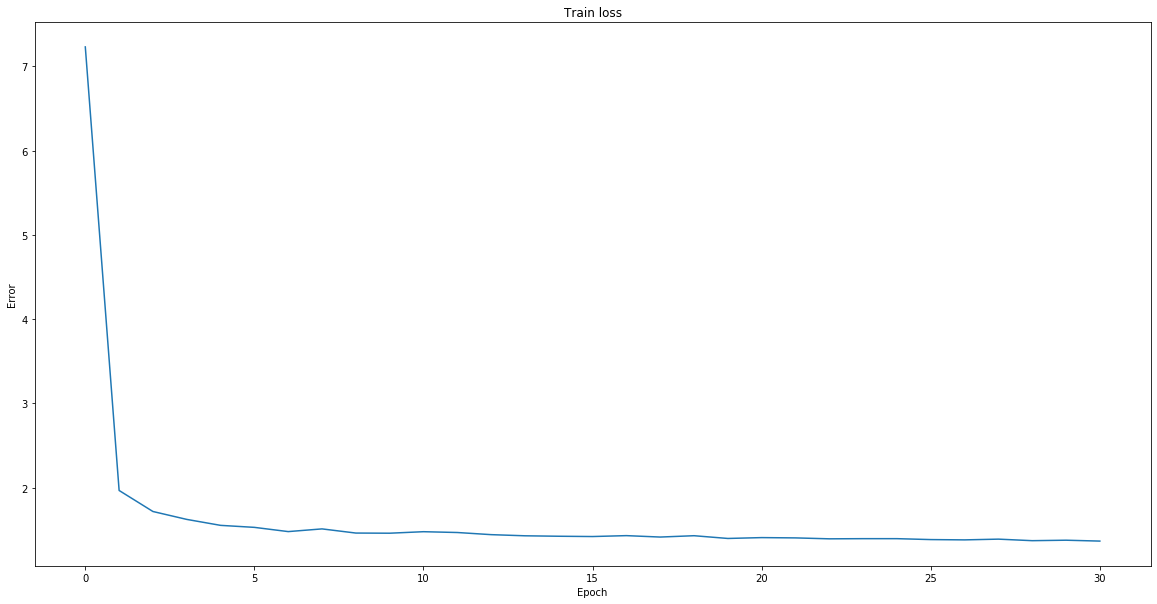

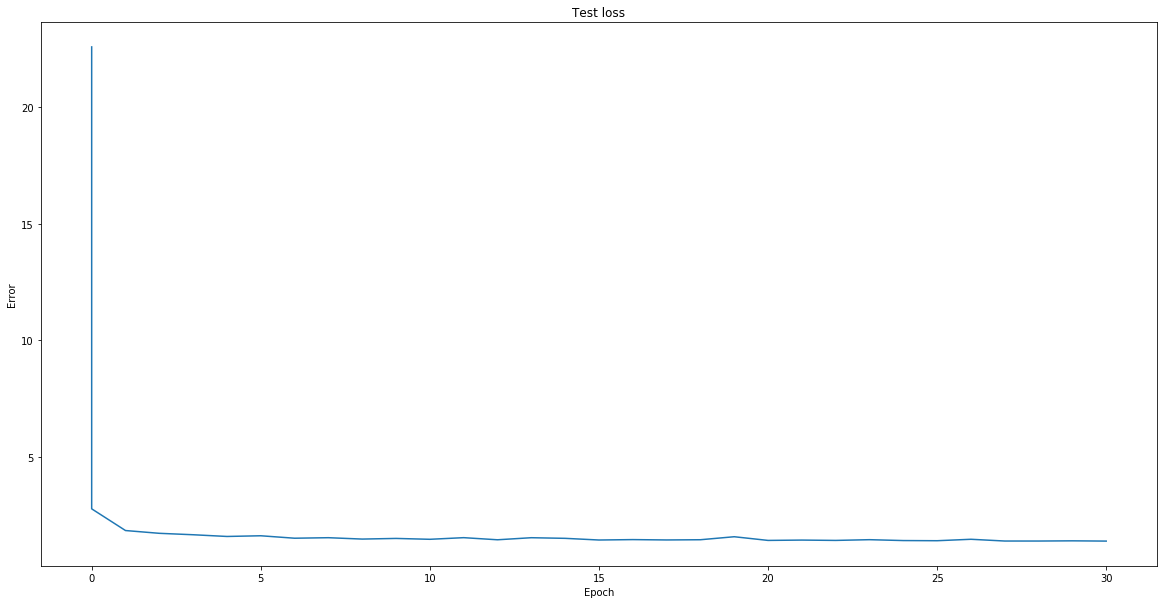

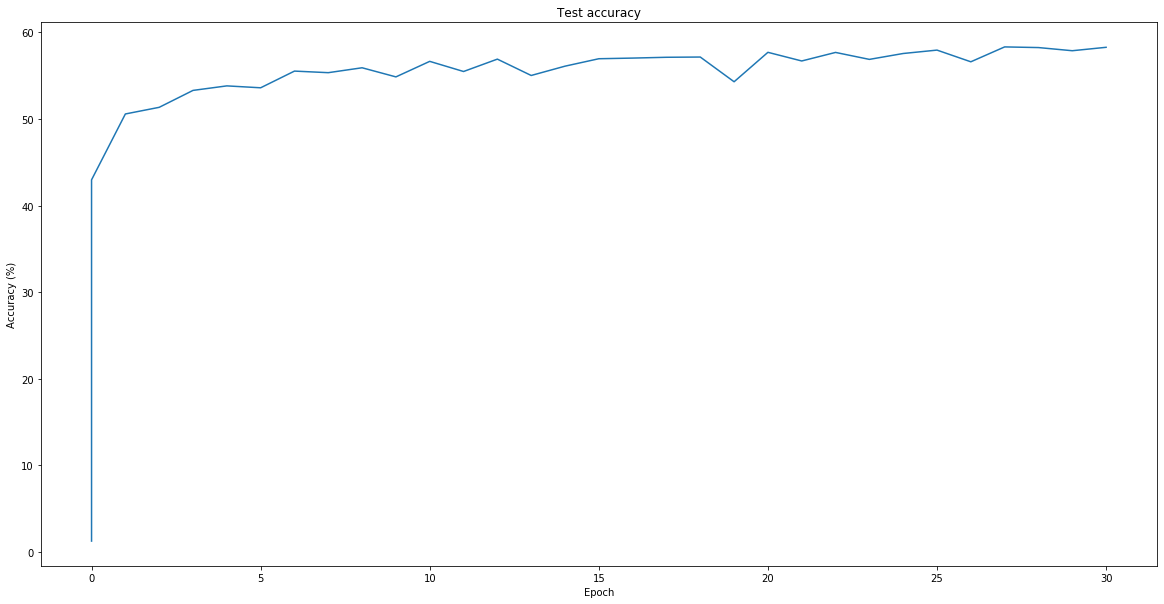

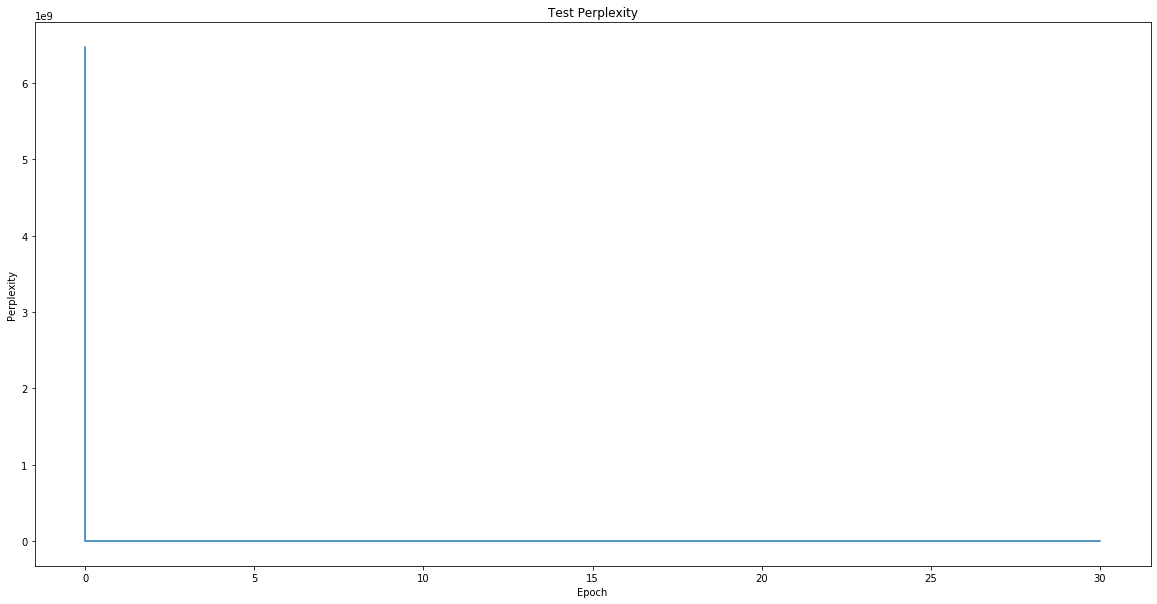

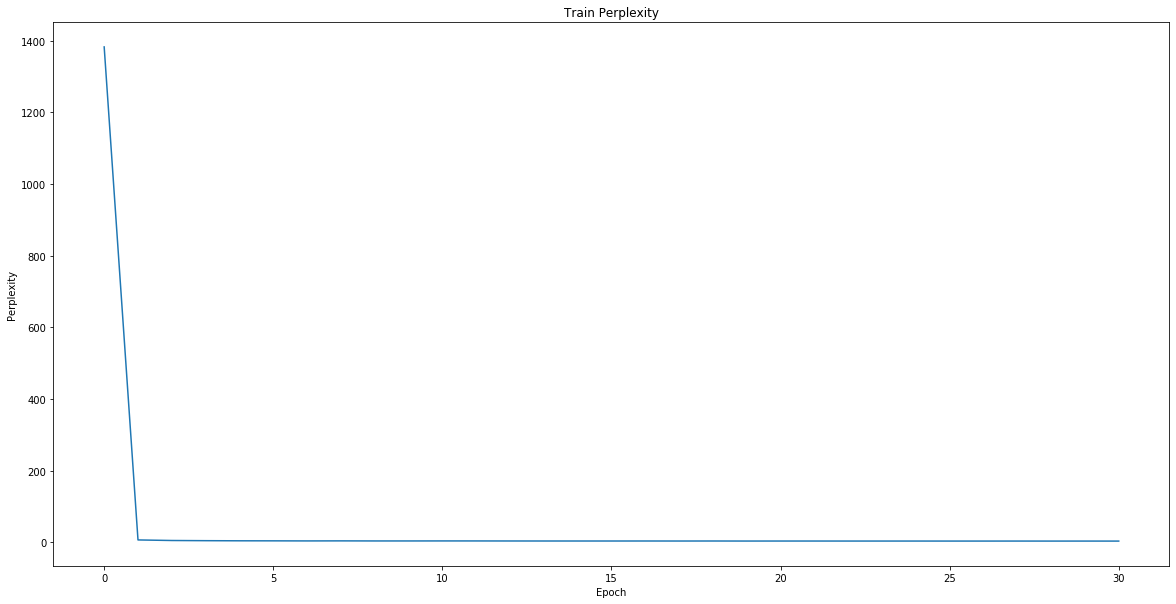

(30, 3.921400427635155)


In [10]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 1024
    TEST_BATCH_SIZE = 180
    EPOCHS = 30
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry looked at me and said '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Accuracy (%)')

        test_perp = []
        train_perp = []
        for i in test_losses:
          test_perp.append((i[0],np.exp(i[1])))
        
        for j in train_losses:
          train_perp.append((j[0],np.exp(j[1]))) 

        ep, val = zip(*test_perp)
        pt_util.plot(ep, val, 'Test Perplexity', 'Epoch', 'Perplexity')

        ep, val = zip(*train_perp)
        pt_util.plot(ep, val, 'Train Perplexity', 'Epoch', 'Perplexity')
        print(train_perp[-1])
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [11]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry grabbed the wand and'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry grabbed the wand and started to the stairs, the stairs and started to the stairs, the stairs and started to the stairs, the stairs and started to the stairs, the stairs and started to the stairs, the stairs and started to
generated with sample	 Harry grabbed the wand and screamed back of the corridors, the sudden was not to be all the others and strugged to Harry had and been really side of the edge of them. "You haven't said," said Harry, still saying her hand as the
generated with sample	 Harry grabbed the wand and looked at the other shaking her eyes and dearly the Hermione was still at the slight of the side. "It's all the only been anyway, "I've got a tell me," said Ron, and Harry said to see the end of the s
generated with sample	 Harry grabbed the wand and, standing side of the back of the tight, but nothing slightly, back and the only stingly broomsticked as the stairs of the creeped in the contentles. The other side of the class with his wand and in t

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    